# Generating images using VAE

Now that we have understood how Variational Autoencoders(VAE) works, in this section we will learn how to use VAE to generate images.


## Import the required libraries


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


## Prepare the dataset

Load the MNIST dataset:

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

Normalize the dataset:

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Reshape the dataset:

In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Now the shape of data would become:

In [5]:
print(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))


Now, let's define some important parameters:

In [6]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0

## Defining Encoder


Define the input:

In [7]:
x = Input(shape=(original_dim,))

Define the Encoder hidden layer:

In [8]:
h = Dense(intermediate_dim, activation='relu')(x)


Compute mean and variance:

In [9]:
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


## Define the sampling operation


Define the sampling operation with a reparameterization trick which samples the latent vector form the encoder's distribution:


In [10]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var / 2) * epsilon

Sample the latent vector z from the mean and variance of the encoder's distribution:

In [11]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

## Define the Decoder

We define the decoder with two layers:

In [12]:
decoder_hidden = Dense(intermediate_dim, activation='relu')
decoder_reconstruct = Dense(original_dim, activation='sigmoid')

Reconstruct images using the decoder:

In [13]:
decoded = decoder_hidden(z)
reconstructed = decoder_reconstruct(decoded)

## Build the model

In [14]:
vae = Model(x, reconstructed)

### Define the loss


As we learned we use two types of loss: Reconstruction loss and KL divergence loss


Reconstuction loss is defined as:

In [15]:
Reconstruction_loss = original_dim * metrics.binary_crossentropy(x, reconstructed)

KL diveregnce loss is defined as:

In [16]:
kl_divergence_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

Thus our total loss becomes:

In [17]:
total_loss = K.mean(Reconstruction_loss + kl_divergence_loss)



Add loss and compile the model

In [18]:
vae.add_loss(total_loss)
vae.compile(optimizer='rmsprop')

Train the model

In [19]:
vae.fit(x_train,shuffle=True, epochs=epochs, batch_size=batch_size,verbose=2, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 189.6828 - val_loss: 171.2307
Epoch 2/10
 - 6s - loss: 169.0377 - val_loss: 167.7445
Epoch 3/10
 - 6s - loss: 166.3774 - val_loss: 165.3534
Epoch 4/10
 - 6s - loss: 164.3107 - val_loss: 164.0418
Epoch 5/10
 - 7s - loss: 162.7984 - val_loss: 162.3211
Epoch 6/10
 - 7s - loss: 161.6029 - val_loss: 161.3738
Epoch 7/10
 - 7s - loss: 160.5524 - val_loss: 160.5113
Epoch 8/10
 - 7s - loss: 159.5963 - val_loss: 159.8307
Epoch 9/10
 - 7s - loss: 158.7382 - val_loss: 158.5780
Epoch 10/10
 - 7s - loss: 157.9101 - val_loss: 157.8535


## Defining Generator

Now, we define the generator that samples from the learned distribution and generates an image. Decoder is bascially our generator as it generates the images. Define the two layers of decoder:

In [20]:
decoder_input = Input(shape=(latent_dim,))
_decoded = decoder_hidden(decoder_input)


Define the generator:

In [21]:
_reconstructed = decoder_reconstruct(_decoded)
generator = Model(decoder_input, _reconstructed)


## Plotting generated images


Now, we plot the image generated by the generator

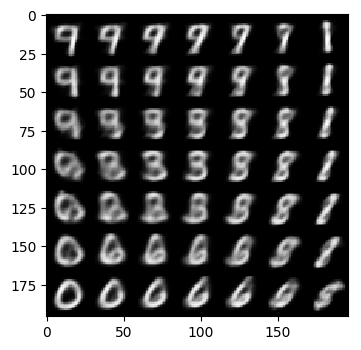

In [22]:
n = 7 
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(figure, cmap='Greys_r')
plt.show()

The above plot shows the generated images by the VAE. Thus, in this chapter, we have learned about several interesting types of autoencoders, in the next chapter we will learn about few-shot learning algorithms.